## Import the required libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Read the data from the .csv file and transfer it to a Pandas DataFrame

In [4]:
# Load dataset from csv file
columnNames = ['mntcm', 'mxtwm', 'rfseas', 'tann', 'latitude', 'longitude', 'y']
data = pd.read_csv('dataset_bees.csv', names=columnNames)

## Balance the data by removing all outliers

This works by using a custom-made algorithm based on the euclidian distance. Since the imbalanced data comes from pseudo-absences (label 0) that are between the presences (label 1) it is only natural to remove all the pseudo-absences that are close to the presences by a determined threshold. The optimal threshold is **23** units of distance.

This method proved to be super efficient giving excelent results in the evaluation phase.

In [6]:
# Define threshold
threshold = 23.0

# Divide the data into positives and negatives
data_positives = data[data['y'] == 1]
data_negatives = data[data['y'] == 0]
    
# Cycle through all the positives
for index, row in data_positives.iterrows():
    # Get the latitude and longitude of the positive
    lat = row['latitude']
    lon = row['longitude']
    # Get the euclidian distance between the positive and all the negatives
    distance = np.sqrt((data_negatives['latitude'] - lat)**2 + (data_negatives['longitude'] - lon)**2)
    
    # Remove all the negatives that are too close to the positive
    data_negatives = data_negatives[distance > threshold]

# Return the new data
data = pd.concat([data_positives, data_negatives])

## Deal with the missing values in the dataset (NaN values)

There are many algorithms developed to deal with missing values. Some aim to remove missing values others to fill these. In this context, and since the missing values belong to the presences, it is crucial not to delete them. Therefore every NaN value will be replaced by the average of all values ​​belonging to the same class (in this case class 1).

In [7]:
# Deal with missing values in dataset (replace with mean value of rows with the same y (label) value)) 
data = data.fillna(data.groupby('y').transform('mean'))

## Split the data into features and labels and then split it into training and testing data 

In [8]:
# Split dataset into features and labels
X = data[['mntcm', 'mxtwm', 'rfseas', 'tann']]
y = data['y']

# Split the dataset randomly into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Standardize the feature values to be between 0 and 1

This way we get a better performance since the descrepancy between values is smaller.

In [9]:
# Standardize features values to be between 0 and 1 (for better performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Create a list of the pretended classifiers

This way code is not only cleaner and more optimized, but also more readable.

In [10]:
# Create a list of classifiers
classifiersNames = ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression', 'Multilayer Perceptron']
classifiers = [ KNeighborsClassifier(n_neighbors=3),
                DecisionTreeClassifier(),
                RandomForestClassifier(n_estimators=100),
                SVC(),
                LogisticRegression(),
                MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
            ]

## Train each classifier

Because all the classifiers are in a list it's easy to train them all

In [11]:
# Train each classifier
for classifier in classifiers:
    classifier.fit(X_train, y_train)

## Evaluate each classifier using cross validation

StratifiedKFold evaluation with 10 folds and shuffle.

In [24]:
# Evaluate each classifier using cross validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

# Store the average score of 10 folds for each classifier
avgScore = []

for classifier, name in zip(classifiers, classifiersNames):
    scores = cross_val_score(classifier, X, y, cv=skf) # cross_val_score returns the f1 score for each fold of the cross validation (10 folds) 
    avgScore.append(scores.mean())
    print(name + ' : ' + str(scores.mean())) # Print the mean of the f1 scores

KNN : 0.9763157894736842
Decision Tree : 0.9789473684210526
Random Forest : 0.9815789473684211
SVM : 0.9605263157894737
Logistic Regression : 0.9631578947368421
Multilayer Perceptron : 0.9789473684210526


## Plot the cross validation in an histogram

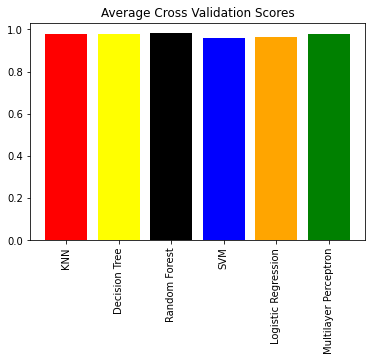

In [42]:
plt.figure()
plt.title("Average Cross Validation Scores")
plt.xticks(rotation='vertical')
c = ['red', 'yellow', 'black', 'blue', 'orange', 'green']
plt.bar(classifiersNames, avgScore, color=c, align="center")
plt.show()

## Plot the ROC curve and AUC

Instead of ploting the ROC curve and AUC with the fold values i found it better to simply use the roc_curve() function provided by scikit learn.

**fpr**: False positive rates;

**tpr**: True positive rates.

Since all classifiers are in a list, dictionaries of fpr, tpr and auc were created to make it easy to access the values of each classifier.

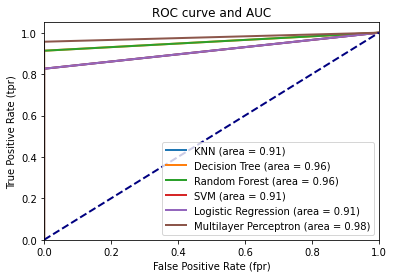

In [45]:
# Create dictionaries to store the values of each classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for classifier, name in zip(classifiers, classifiersNames):
    y_pred = classifier.predict(X_test)
    fpr[name], tpr[name], _ = roc_curve(y_test, y_pred) 
    roc_auc[name] = auc(fpr[name], tpr[name])

# Plot all ROC curves
plt.figure()
lw = 2
for name in classifiersNames:
    plt.plot(fpr[name], tpr[name], lw=lw, label=name + ' (area = %0.2f)' % roc_auc[name])
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title('ROC curve and AUC')
plt.legend(loc="lower right")
plt.show()

## Find the best classifier using F1 score

According to multiple sources, the F1 score is the best metric to determine the best classifier out of the bunch. Therefore i scored each model and chose the one with the highest score.

In [34]:
bestClassifier = classifiers[0]
bestClassifierName = classifiersNames[0]
bestScore = 0

# List of f1 scores
f1Scores = []

for classifier, name in zip(classifiers, classifiersNames):
    y_pred = classifier.predict(X_test)
    score = classifier.score(X_test, y_test)
    f1Scores.append(score)
    if score >= bestScore:
        bestClassifier = classifier
        bestClassifierName = name
        bestScore = score

# Print the best classifier
print('Best classifier: ' + bestClassifierName + ' with score: ' + str(bestScore))

Best classifier: Multilayer Perceptron with score: 0.9868421052631579


## Plot the F1 scores for each classifier

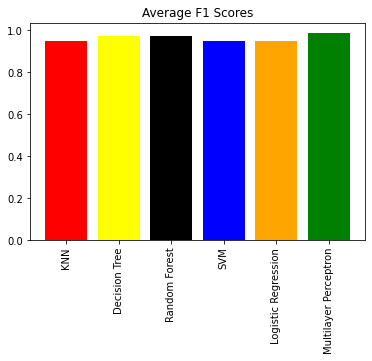

In [43]:
plt.figure()
plt.title("Average F1 Scores")
plt.xticks(rotation='vertical')
plt.bar(classifiersNames, f1Scores, color=c, align="center")
plt.show()

## Predict the test dataset using the best classifier

In [15]:
# Predict using the best classifier
y_pred = bestClassifier.predict(X_test)

## Print the classification report of the best classification model

Scikit learn offers a method that prints a detailed report of a classification model.

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        53
         1.0       1.00      0.96      0.98        23

    accuracy                           0.99        76
   macro avg       0.99      0.98      0.98        76
weighted avg       0.99      0.99      0.99        76

